In [18]:
%%capture
%%bash

apt install -y libboost-all-dev
pip install -U pip
pip install "pybind11[global]"

pip install aijack

In [19]:
import os
import copy
import random

import kagglehub

import numpy as np
import pandas as pd

from aijack.attack import Poison_attack_sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [20]:
random.seed(42)

Загрузим данные

In [21]:
path = kagglehub.dataset_download("dhoogla/distrinetcicids2017")
print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5


In [22]:
dfps = []

for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps.append(dfp)
            print(dfp)

/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/Portscan-DDos-Botnet-Friday.parquet
/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/DoS-Wednesday.parquet
/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/Bruteforce-Tuesday.parquet
/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/Infiltration-Webattacks-Thursday.parquet
/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/Benign-Monday.parquet


In [23]:
dfps = [dfp for dfp in dfps if not 'Benign' in dfp]

In [25]:
df = pd.concat([pd.read_parquet(dfp) for dfp in dfps], ignore_index=True)
df.shape

(1436640, 83)

Датасет предназначен для задачи многоклассовой классификации, но мы упростим ее и сведем к бинарной - бинарная классификация на нормальный и аномальный трафик.

In [26]:
target = 'Label'

df[target] = df[target].replace('Attempted-relabel-as-Benign', 'Benign')
df.Label.value_counts() # benign - хороший трафик, остальное - нет

Label
Benign                        1154753
DoS Hulk                       158449
DDoS                            95144
DoS GoldenEye                    7567
Infiltration - Portscan          5485
DoS Slowloris                    3998
FTP-Patator                      3972
SSH-Patator                      2961
DoS Slowhttptest                 1741
Portscan                         1683
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: count, dtype: int64

In [27]:
df.loc[df['Label'] != 'Benign', 'Label'] = 1
df.loc[df['Label'] == 'Benign', 'Label'] = 0

df['Label'] = df['Label'].astype(dtype=np.int32)

df['Label'].value_counts(normalize=True)

Label
0    0.803787
1    0.196213
Name: proportion, dtype: float64

### Train-test split

Для ускорения обучения моделей используем лишь часть данных

In [28]:
X, X_test, y, y_test = train_test_split(
    df.drop(columns=['Label']),
    df['Label'],
    test_size=0.01,
    random_state=42,
)
X, X_train, y, y_train = train_test_split(
    X,
    y,
    test_size=0.05,
    random_state=42,
)
X_train.shape, X_test.shape

((71114, 82), (14367, 82))

### Constant Baseline

Константный бейзлайн в виде самого частотного класса предсказуемо не показывает хорошего качества

In [29]:
roc_auc_score(y_true=y_test, y_score=[0.0]*len(y_test))

0.5

### SVM

Метод опорных векторов, напротив, демонстрирует хорошую производительность...

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = SVC(kernel="linear", C=1, random_state=42)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
roc_auc_score(y_true=y_test, y_score=y_pred)

0.9844379385819594

#### SVC Interpretation

Давайте выясним, почему эта модель так хорошо работает.

Интерпретируйте работу обученной SVC-модели в ячейке ниже, для этого создайте bar-plot с визуализацией весов модели.

**Hint**: метод опорных векторов является линейной моделью, поэтому его интерпретация мало чем отличается от интерпретации линейной регрессии

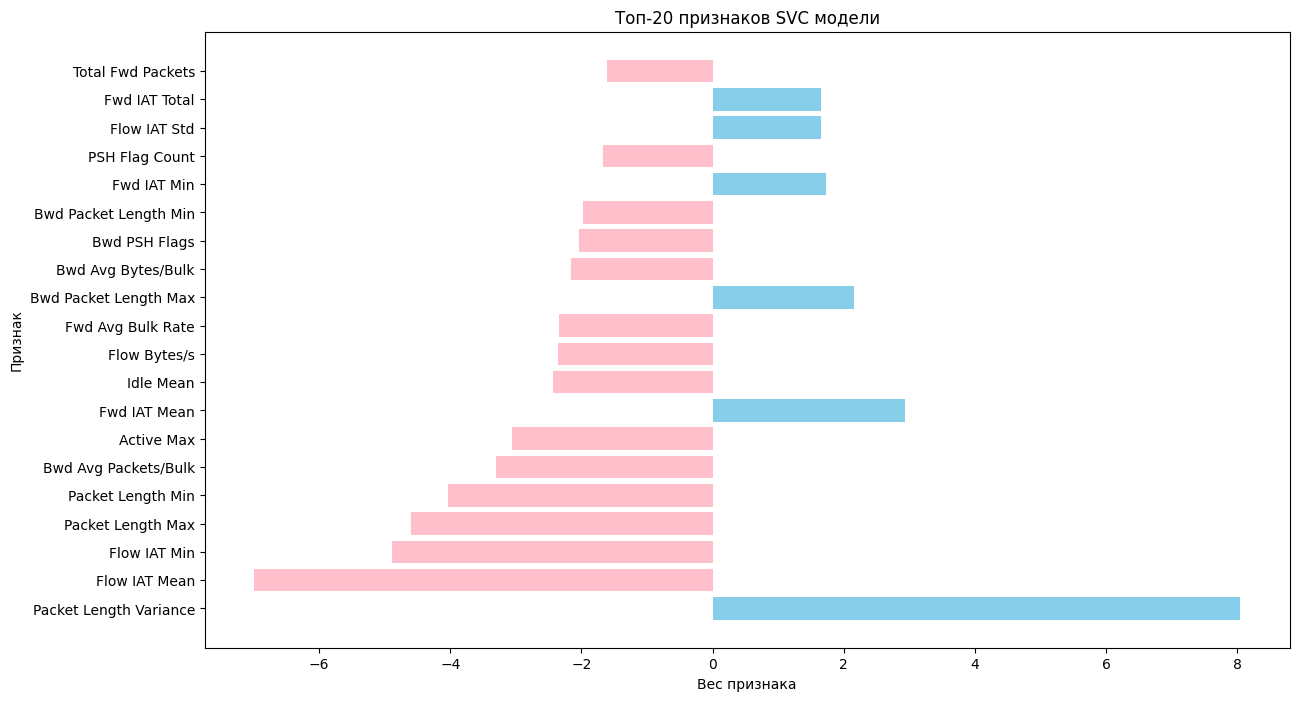

In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Создаем DataFrame
w8s_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Weight': model.coef_[0]
})

# Сортируем DataFrame по абсолютному значению весов в порядке убывания и оставляем первые 20
w8s_df['Abs_Weight'] = w8s_df['Weight'].abs()
w8s_df = w8s_df.sort_values(by='Abs_Weight', ascending=False).head(20)

# Визуализируем
plt.figure(figsize=(14, 8))
colors = ['skyblue' if w > 0 else 'pink' for w in w8s_df['Weight']]
plt.barh(w8s_df['Feature'], w8s_df['Weight'], color=colors)
plt.xlabel('Вес признака')
plt.ylabel('Признак')
plt.title('Топ-20 признаков SVC модели')
plt.show()

#### SVC Attack - Data poison

Выберем объект, который будем "отравлять"

In [32]:
# initial point
initial_idx = 11
xc = copy.deepcopy(X_train_scaled[initial_idx, :])
yc = y_train.iloc[initial_idx]

Создадим небольшие train/test подвыборки для ускорения процесса обучения

In [33]:
train_idx = random.sample(list(range(1, X_train_scaled.shape[0])), 500)
X_train_ = copy.copy(X_train_scaled[train_idx, :])
y_train_ = copy.copy(y_train.iloc[train_idx]).values

In [34]:
test_idx = random.sample(list(range(1, X_test_scaled.shape[0])), 500)
X_test_ = copy.copy(X_test_scaled[test_idx, :])
y_test_ = copy.copy(y_test.iloc[test_idx]).values

aijack ожидает, что метки классов будут иметь вид 1/-1

In [35]:
y_train_ = np.where(y_train_ == 1, 1, -1)
y_test_ = np.where(y_test_ == 1, 1, -1)

Создайте attacker и "отравленный" объект

In [36]:

attacker = Poison_attack_sklearn(model,X_train_,y_train_,t=0.7)

xc_attacked, log = attacker.attack(xc,1,X_test_,y_test_,num_iterations=222)

Посмотрим, насколько будет падать качество классификации до и после добавления "отравленного" объекта в модель

In [37]:
clf = SVC(kernel="linear", C=1, random_state=42)
clf.fit(X_train_, y_train_)
print("before attack: ", roc_auc_score(y_true=y_test_, y_score=clf.predict(X_test_)))

# add poinsoned data
clf = SVC(kernel="linear", C=1, random_state=42)
clf.fit(
    np.concatenate([X_train_, xc_attacked.reshape(1, -1)]),
    np.concatenate([y_train_, [-1]]),
)

assert roc_auc_score(y_true=y_test_, y_score=clf.predict(X_test_)) < 0.9769
print("after attack: ", roc_auc_score(y_true=y_test_, y_score=clf.predict(X_test_)))

before attack:  0.9445720221985292
after attack:  0.9377374996582739


### Random Forest

Обучите модель случайного леса для рещения задачи

In [38]:
%%time

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
roc_auc_score(y_true=y_test, y_score=rf.predict(X_test))

CPU times: user 27.1 s, sys: 21.8 ms, total: 27.1 s
Wall time: 29.4 s


0.9974053415065487

#### Random Forest Interpretation

Интерпретируйте предсказания случайного леса
- с использованием `permutation_importance`
- с использованием `shap`
- с использованием `lime` для двух любых объектов - с метками 0 и 1

In [39]:
from sklearn.inspection import permutation_importance

In [40]:
PerI = permutation_importance(rf, X_test, y_test, random_state=42)
sorted_features = PerI.importances_mean.argsort()

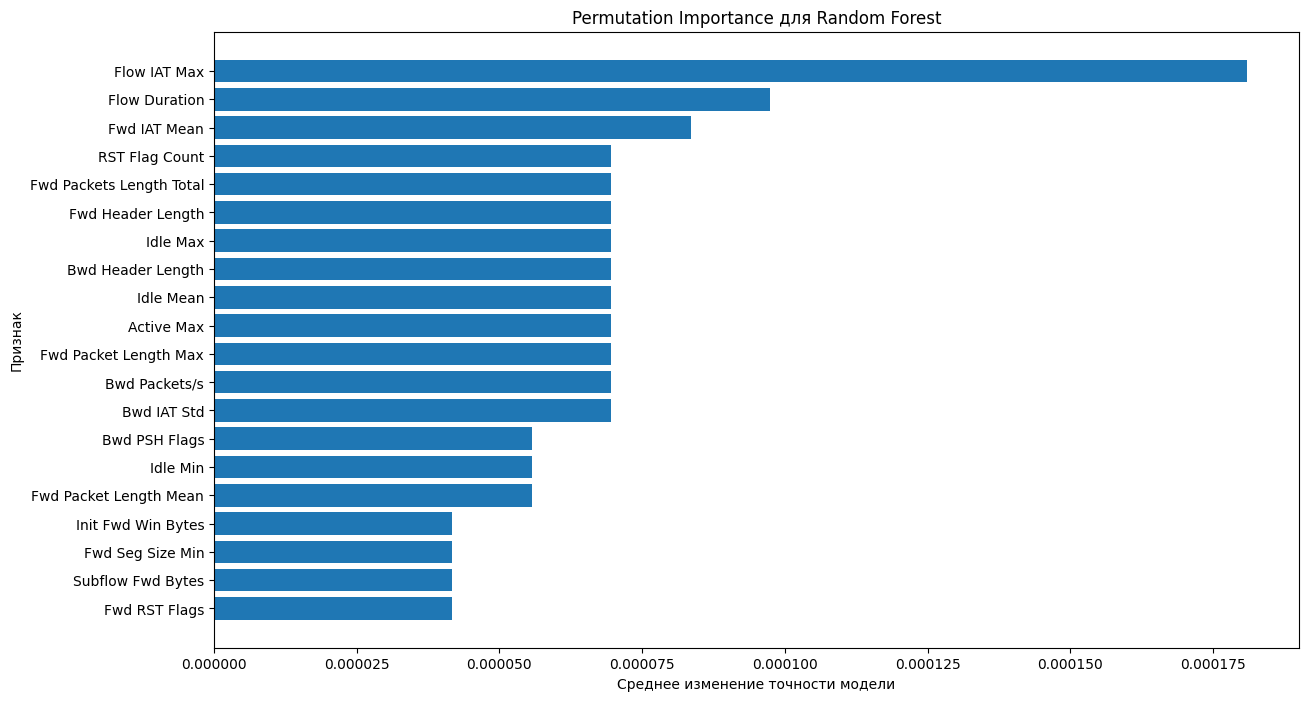

In [41]:
# Визуализируем 20 наиболее важных признаков
plt.figure(figsize=(14, 8))
plt.barh(X_train.columns[sorted_features][-20:], PerI.importances_mean[sorted_features][-20:])
plt.xlabel("Среднее изменение точности модели")
plt.ylabel("Признак")
plt.title("Permutation Importance для Random Forest")
plt.show()

In [42]:
import shap

In [43]:
shp_Exp = shap.Explainer(rf)
shp_vals = shp_Exp(X_test)

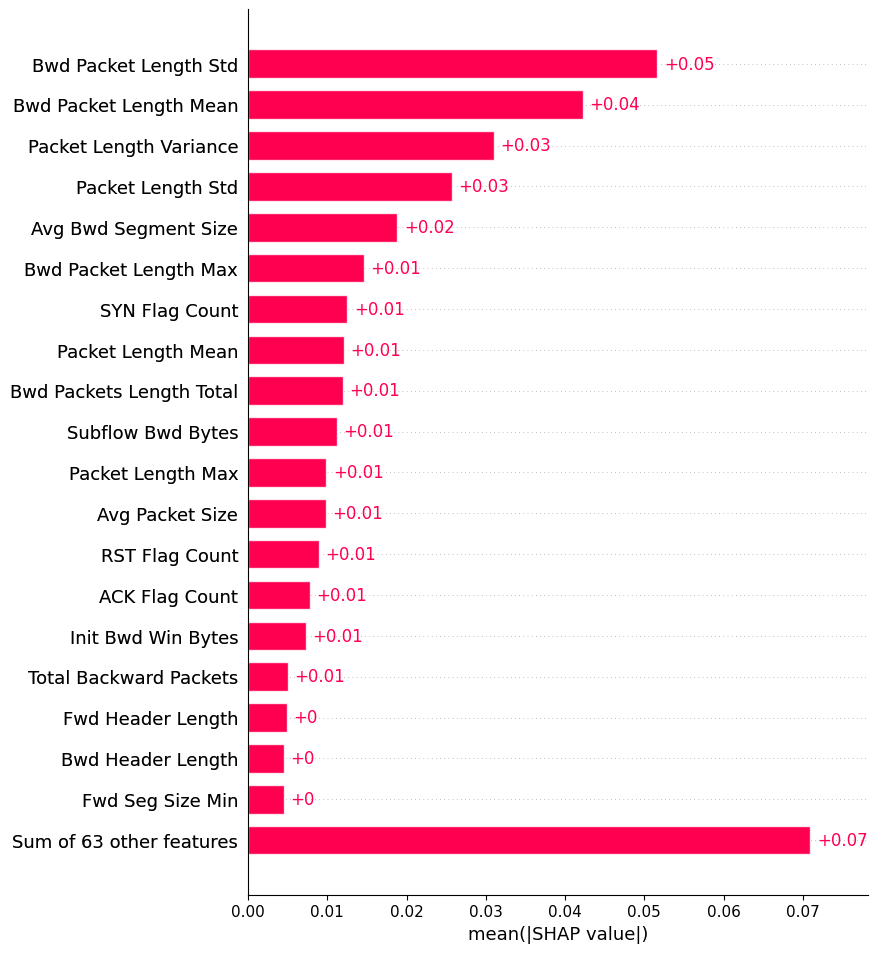

In [44]:
shp_vals_c0 = shp_vals[..., 0]
shap.plots.bar(shp_vals_c0, max_display=20)

In [48]:
!pip install lime
import lime
from lime import lime_tabular

In [49]:
# Создаем LIME объяснителя для классификации
L_exp = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    training_labels=y_train,
    verbose=True,
    mode='classification',
)

In [50]:
# Интерпретация для первого объекта (класс 0)
L_exp.explain_instance(X_test.iloc[60].values, rf.predict_proba, num_features=20).show_in_notebook(show_table=True)

Intercept 0.22750824226571728
Prediction_local [0.27652208]
Right: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [71]:
L_exp.explain_instance(X_test.iloc[4561].values, rf.predict_proba, num_features=20).show_in_notebook(show_table=True)

Intercept 0.12119499928730187
Prediction_local [0.47835916]
Right: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
